In [12]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

In [53]:
path = os.path.expanduser('~/Data_607_Final_Project') # Your file must have the same name.
os.chdir(path) # Change this to your working directory
train = pd.read_json('~/DATA602_Final_Project/data/processed/train.json')

In [4]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [5]:
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

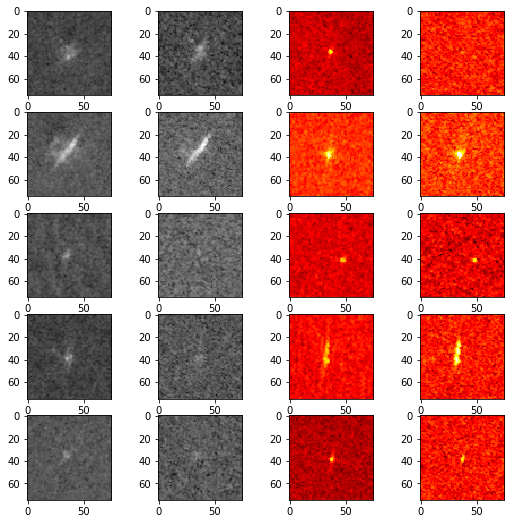

In [54]:
icebergs = train[train.is_iceberg==1].sample(n=5,random_state=123)
ships = train[train.is_iceberg==0].sample(n=5,random_state=123)

# Plot band_1 and band_2, gray for icebergs, hot for not iceberg
fig = plt.figure(1, figsize=(9, 9))
for i in range(5):
    ax = fig.add_subplot(5, 4, 4*i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))  # HH
    ax.imshow(arr,cmap='gray', vmin=-39, vmax=21)
    ax = fig.add_subplot(5, 4, 4*i+2)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))  # HV
    ax.imshow(arr,cmap='gray', vmin=-39, vmax=-3)
    ax = fig.add_subplot(5, 4, 4*i+3)
    arr = np.reshape(np.array(ships.iloc[i,0]),(75,75))  # HH
    ax.imshow(arr,cmap='hot', vmin=-39, vmax=21)
    ax = fig.add_subplot(5, 4, 4*i+4)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))  # HV
    ax.imshow(arr,cmap='hot', vmin=-39, vmax=-3)
    
fig.savefig('bergs_and_ships.png')

In [13]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

In [14]:
Xtrain = get_scaled_imgs(train)
Ytrain = np.array(train['is_iceberg'])


train.inc_angle = train.inc_angle.replace('na',0)
idx_tr = np.where(train.inc_angle>0)


Ytrain = Ytrain[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]

In [91]:
arr = np.reshape(np.array(icebergs.iloc[0,0]),(75,75))

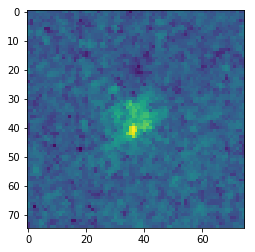

In [92]:
plt.imshow(arr, interpolation='nearest')
plt.show()

In [42]:
train.loc[0,0]

TypeError: cannot do label indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [0] of <class 'int'>

In [37]:
from scipy import ndimage
gauss_denoised = ndimage.gaussian_filter(arr, 2)

In [30]:

Xtrain[0,0].shape

(75, 3)

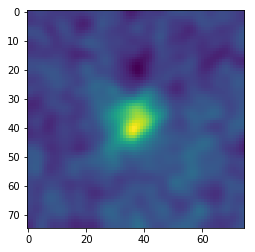

In [38]:

imgplot = plt.imshow(gauss_denoised)

IndexError: single positional indexer is out-of-bounds

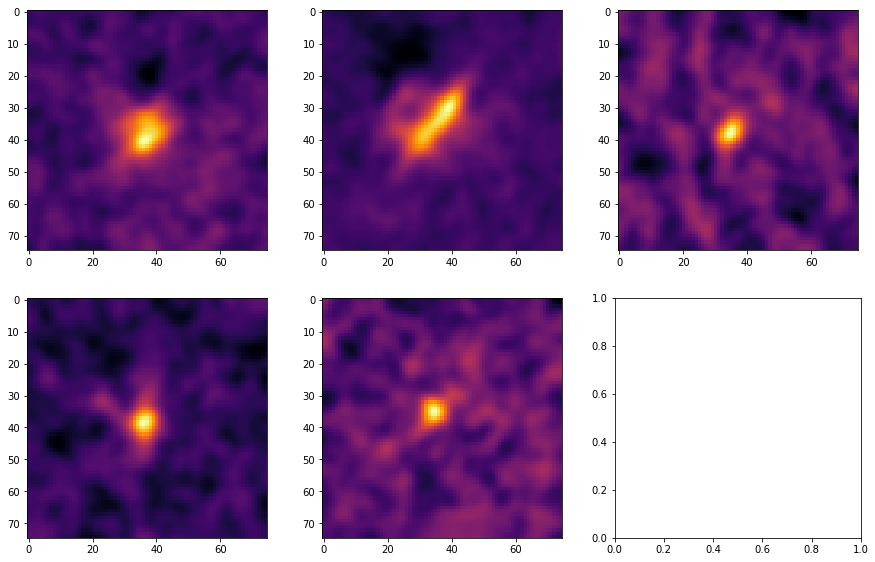

In [58]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))
    arr = ndimage.gaussian_filter(arr, 2)
    ax.imshow(arr,cmap='inferno')
    
plt.show()

In [49]:
def preprocess(df):
    """
    Function to take a column of a DF and preprocess it to make a CNN more accurate
    """
    # Reshape the image:
    arr = np.reshape(np.array(icebergs.loc[i,0]),(75,75))
    arr = ndimage.gaussian_filter(arr, 2)

In [79]:
for i in range(len(icebergs)):
    arr = np.reshape(np.array(icebergs.iloc[[0],[0]]),(75,75))
    arr = ndimage.gaussian_filter(arr, 2)

ValueError: cannot reshape array of size 1 into shape (75,75)

In [46]:
len(train)

1604

/Applications/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


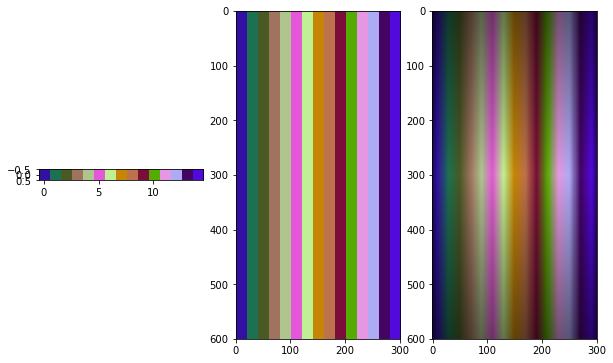

In [28]:
from skimage import transform as tf
import matplotlib.pyplot as plt
import numpy as np
data = np.random.random((1, 15, 3))*255
data = data.astype(np.uint8)
new_data = tf.resize(data, (600, 300, 3), order=0) # order=0, Nearest-neighbor interpolation
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 10))
ax1.imshow(data)
ax2.imshow(new_data)
ax3.imshow(tf.resize(data, (600, 300, 3), order=1))

# Denoise steps:
1. Use a de-noise algorithm like: http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html
1. Correct for brighter pictures with the mean: http://yeephycho.github.io/2016/08/03/normalizations_in_neural_networks/ It may be useful to use the equalized algorithm.
1. Take the first derivative of each image: https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
1. Look at combing two bands into one image (e.g, just concatinating the strings). Maybe do this step first.
1. Set up data in a way that TF or sklearn can work with.
1. Train/Test split
1. Train Data
1. Cross Validate
1. Run on Kaggle test data

In [68]:
train.shape

(1604, 5)

In [87]:
train.iloc[[1],[0]]

,band_1
1,"[-12.242375, -14.920304999999999, -14.920363, ..."


In [81]:
train[[0],[0]]

TypeError: unhashable type: 'list'

In [90]:
train.iloc[[1],[0]]

,band_1
1,"[-12.242375, -14.920304999999999, -14.920363, ..."


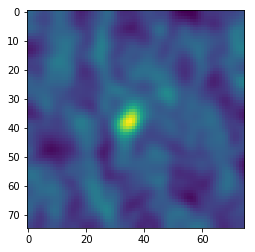

In [96]:
arr = np.reshape(np.array(icebergs.iloc[2,0]),(75,75))
gauss_denoised = ndimage.gaussian_filter(arr, 2)
imgplot = plt.imshow(gauss_denoised)

In [99]:
# A way to reshape over all classes
for i in range(5):
    print(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)))

[[-24.409096 -23.279524 -22.865889 ..., -20.574692 -25.435507 -24.908985]
 [-23.494003 -22.666204 -23.279636 ..., -21.559107 -22.669508 -22.669508]
 [-22.280045 -22.471008 -23.714024 ..., -21.559107 -23.497364 -23.073633]
 ..., 
 [-23.496243 -23.941826 -22.095596 ..., -23.49955  -22.285652 -22.476614]
 [-27.578697 -23.716261 -22.095596 ..., -20.733555 -22.285707 -22.285707]
 [-27.578697 -23.716261 -23.716318 ..., -21.220741 -19.977839 -21.055403]]
[[-20.308092 -18.846018 -20.907494 ..., -15.875124 -19.751593 -16.412703]
 [-18.846018 -17.809452 -19.221142 ..., -22.07127  -19.751593 -17.705559]
 [-18.846018 -15.699248 -19.221142 ..., -19.225014 -20.312235 -17.922787]
 ..., 
 [-15.205494 -16.319496 -19.223858 ..., -17.087528 -16.142548 -16.232626]
 [-17.492407 -17.388451 -17.285727 ..., -17.188013 -16.988396 -17.392532]
 [-22.432079 -16.789253 -17.285727 ..., -18.261778 -16.988396 -18.493483]]
[[-17.932524 -17.60478  -17.822002 ..., -21.975029 -22.909964 -21.627676]
 [-19.124237 -17.18610

In [103]:
np.reshape(np.array(icebergs.iloc[0,0]),(75,75))

array([[-24.409096, -23.279524, -22.865889, ..., -20.574692, -25.435507,
        -24.908985],
       [-23.494003, -22.666204, -23.279636, ..., -21.559107, -22.669508,
        -22.669508],
       [-22.280045, -22.471008, -23.714024, ..., -21.559107, -23.497364,
        -23.073633],
       ..., 
       [-23.496243, -23.941826, -22.095596, ..., -23.49955 , -22.285652,
        -22.476614],
       [-27.578697, -23.716261, -22.095596, ..., -20.733555, -22.285707,
        -22.285707],
       [-27.578697, -23.716261, -23.716318, ..., -21.220741, -19.977839,
        -21.055403]])

In [112]:
temp = np.concatenate((np.reshape(np.array(train.iloc[0,0]),(75,75)), np.reshape(np.array(train.iloc[0,1]),(75,75))), axis =1)

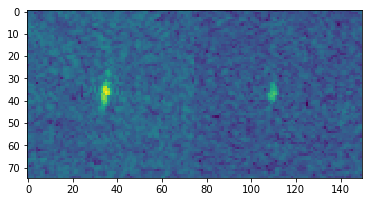

In [119]:
#original
imgplot = plt.imshow(temp)

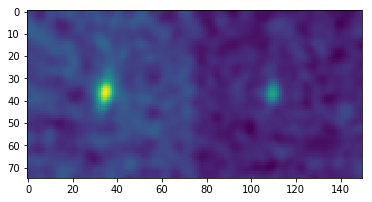

In [113]:

gauss_denoised = ndimage.gaussian_filter(temp, 2)
imgplot = plt.imshow(gauss_denoised)

In [117]:
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
from scipy import signal
temp1 = signal.convolve2d(temp,xder,mode='valid')

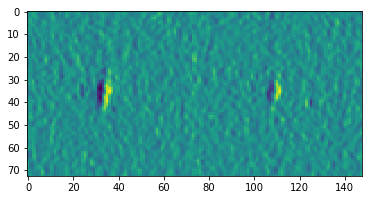

In [118]:
imgplot = plt.imshow(temp1)